In [ ]:
import os   # handling the files
import pickle # storing numpy features
import numpy as np
import zipfile
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = '/content/drive/MyDrive/FLICKER_Dataset'
WORKING_DIR = '/content'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
# Unzip the dataset
zip_file = os.path.join(BASE_DIR, 'flickr8k.zip')
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(WORKING_DIR)

# Verify extraction
extracted_images_dir = os.path.join(WORKING_DIR, 'Images')
extracted_captions_file = os.path.join(WORKING_DIR, 'captions.txt')
if not os.path.exists(extracted_images_dir):
    print("Images folder extraction failed or directory not found!")
else:
    print("Images folder extraction successful!")
if not os.path.exists(extracted_captions_file):
    print("Captions file extraction failed or directory not found!")
else:
    print("Captions file extraction successful!")

Images folder extraction successful!
Captions file extraction successful!


In [64]:
# Load vgg16 Model
model = VGG16()

# restructure model
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

# Summerize
print(model.summary())

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [65]:
# extract features from image
features = {}

for img_name in tqdm(os.listdir(extracted_images_dir)):
    # load the image from file
    img_path = os.path.join(extracted_images_dir, img_name)
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [66]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [67]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [68]:
with open(extracted_captions_file, 'r') as f:
    next(f)
    captions_doc = f.read()

In [69]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [70]:
len(mapping)

8091

In [71]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [72]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [73]:
# preprocess the text
clean(mapping)

In [74]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [75]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [76]:
len(all_captions)

40455

In [77]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [78]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [79]:
vocab_size

8485

In [80]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [81]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [84]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0


In [88]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Create data generator to get data in batch
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # Loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            # Check if the key exists in features before accessing it
            if key in features:
                n += 1
                captions = mapping[key]
                # Process each caption
                for caption in captions:
                    # Encode the sequence
                    seq = tokenizer.texts_to_sequences([caption])[0]
                    # Split the sequence into X, y pairs
                    for i in range(1, len(seq)):
                        # Split into input and output pairs
                        in_seq, out_seq = seq[:i], seq[i]
                        # Pad input sequence, change padding to 'post' for right padding
                        in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                        # Encode output sequence
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                        # Store the sequences
                        X1.append(features[key][0])
                        X2.append(in_seq)
                        y.append(out_seq)
                if n == batch_size:
                    # Convert lists to NumPy arrays with correct dtypes
                    X1 = np.array(X1, dtype=np.float32)
                    X2 = np.array(X2, dtype=np.int32)
                    y = np.array(y, dtype=np.float32)

                    # Specify output signature using tf.TensorSpec
                    output_signature = (
                        (tf.TensorSpec(shape=X1.shape, dtype=tf.float32), tf.TensorSpec(shape=X2.shape, dtype=tf.int32)),
                        tf.TensorSpec(shape=y.shape, dtype=tf.float32)
                    )

                    # Create a generator function
                    def generator():
                        # Yield data as a tuple with the expected nested structure
                        yield ((X1, X2), y)  # Changed this line

                    # Create a tf.data.Dataset from the generator with the output signature
                    dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)

                    yield from dataset.take(1)
                    X1, X2, y = list(), list(), list()
                    n = 0
            else:
                None

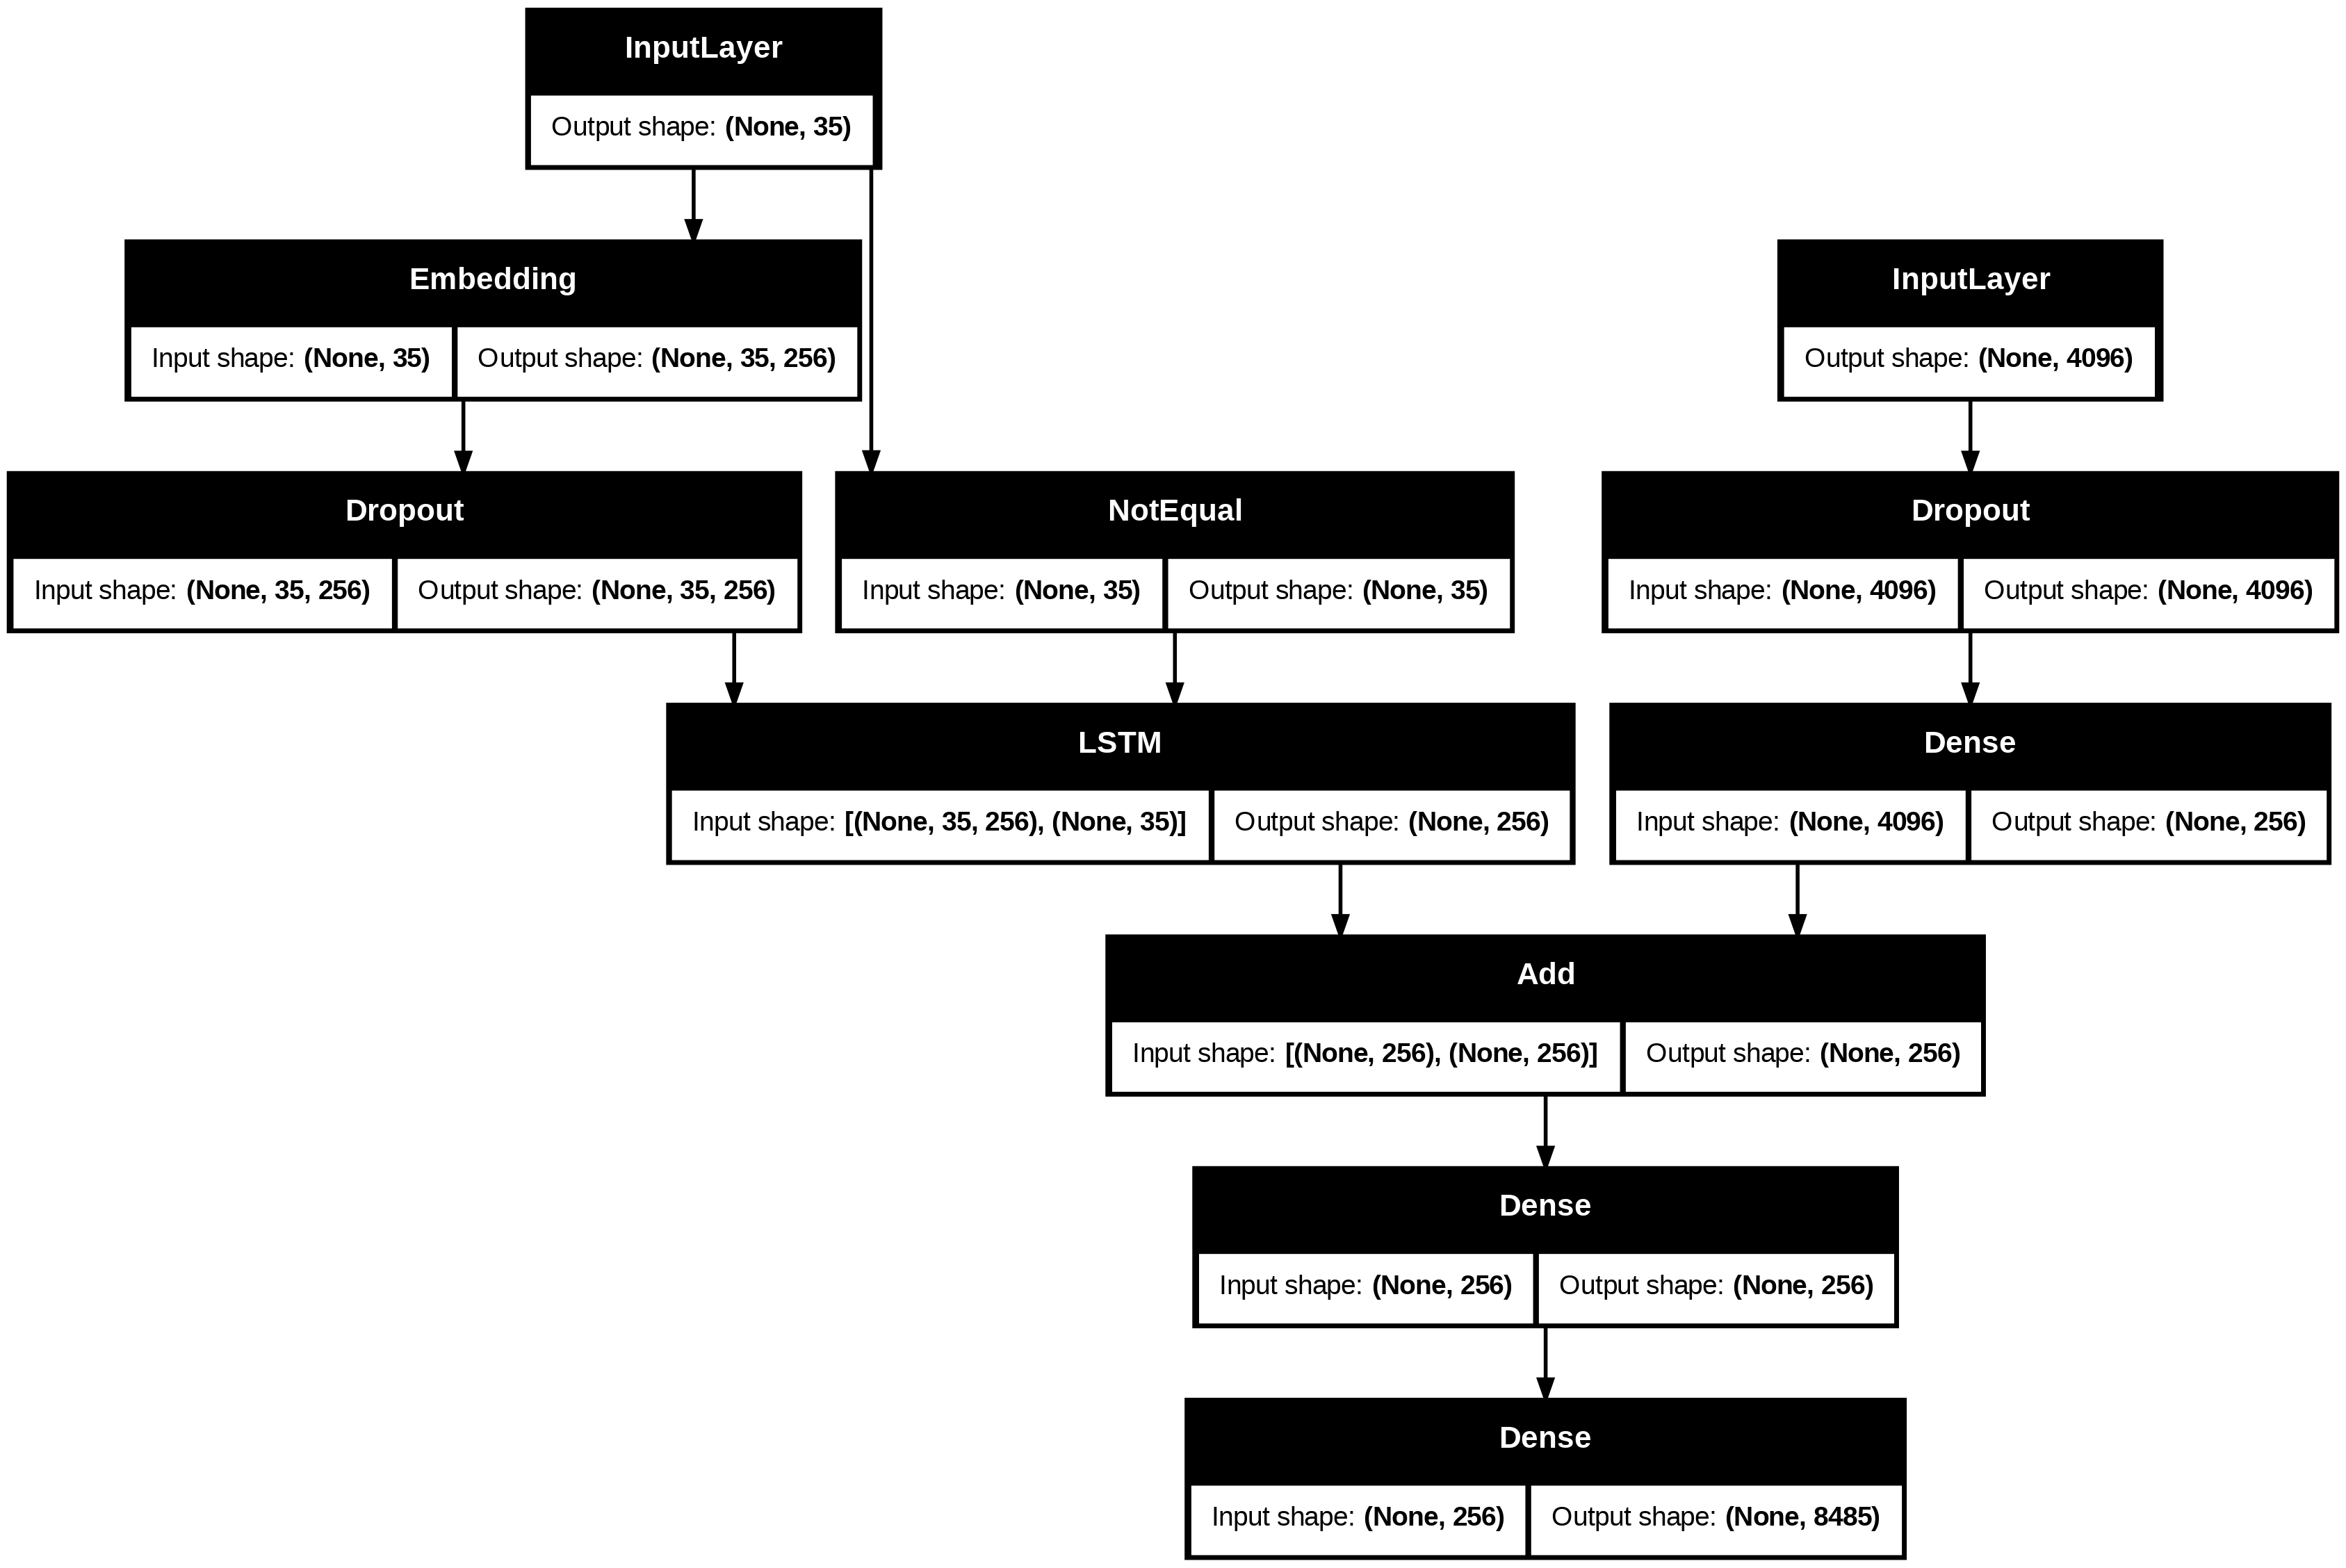

In [89]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [90]:
# train the model
epochs = 15
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 70s 293ms/step - loss: 5.7808
227/227 ━━━━━━━━━━━━━━━━━━━━ 67s 295ms/step - loss: 4.0713
227/227 ━━━━━━━━━━━━━━━━━━━━ 67s 296ms/step - loss: 3.5786
227/227 ━━━━━━━━━━━━━━━━━━━━ 67s 296ms/step - loss: 3.2937
227/227 ━━━━━━━━━━━━━━━━━━━━ 68s 299ms/step - loss: 3.0956
227/227 ━━━━━━━━━━━━━━━━━━━━ 67s 296ms/step - loss: 2.9433
227/227 ━━━━━━━━━━━━━━━━━━━━ 66s 292ms/step - loss: 2.8260
227/227 ━━━━━━━━━━━━━━━━━━━━ 67s 296ms/step - loss: 2.7301
227/227 ━━━━━━━━━━━━━━━━━━━━ 67s 295ms/step - loss: 2.6447
227/227 ━━━━━━━━━━━━━━━━━━━━ 67s 298ms/step - loss: 2.5735
227/227 ━━━━━━━━━━━━━━━━━━━━ 65s 287ms/step - loss: 2.5105
227/227 ━━━━━━━━━━━━━━━━━━━━ 65s 288ms/step - loss: 2.4533
227/227 ━━━━━━━━━━━━━━━━━━━━ 66s 292ms/step - loss: 2.4061
227/227 ━━━━━━━━━━━━━━━━━━━━ 68s 302ms/step - loss: 2.3609
227/227 ━━━━━━━━━━━━━━━━━━━━ 67s 296ms/step - loss: 2.3232


In [91]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [100]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [105]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post') # Change padding to 'post' for right padding
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [106]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


100%|██████████| 810/810 [10:21<00:00,  1.30it/s]


BLEU-1: 0.541261
BLEU-2: 0.316503


In [117]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # Define the paths
    BASE_DIR = '/content/drive/MyDrive/FLICKER_Dataset'

    # Load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(extracted_images_dir, image_name)
    image = Image.open(img_path)

    # Retrieve actual captions from the mapping
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        # Process the caption to remove startseq and endseq
        processed_caption = caption.replace('startseq ', '').replace(' endseq', '')
        print(processed_caption)

    # Predict the caption using the model (assuming predict_caption is defined)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    # Process the predicted caption to remove startseq and endseq
    processed_prediction = y_pred.replace('startseq ', '').replace(' endseq', '')
    print('--------------------Predicted--------------------')
    print(processed_prediction)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()


---------------------Actual---------------------
blonde horse and blonde girl in black sweatshirt are staring at fire in barrel
girl and her horse stand by fire
girl holding horse 's lead behind fire
"a man and girl and two horses are near contained fire ."
two people and two horses watching fire
--------------------Predicted--------------------
man and girl are standing in front of fire


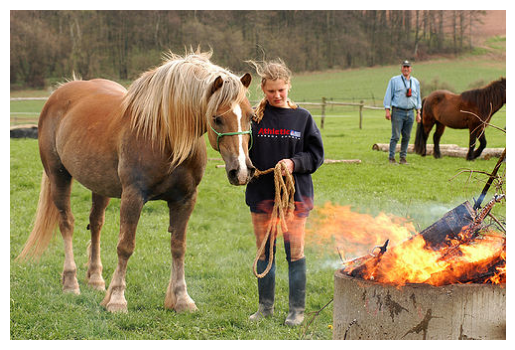

In [118]:
generate_caption('10815824_2997e03d76.jpg')

---------------------Actual---------------------
the black dogs try to wrestle the dog away from each other
there are two blog dogs playing tug-o-war outside
two black dogs playing tug-of-war
two dogs playfully fight over ball outside
"two large black dogs are playing with collapsed ball ."
--------------------Predicted--------------------
two dogs fight in the grass


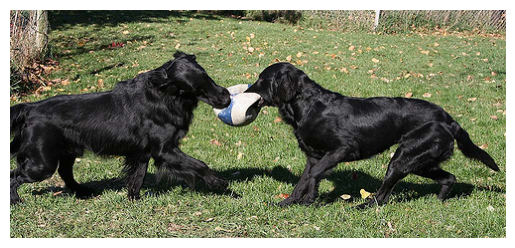

In [122]:
generate_caption("271770120_880e8d8e52.jpg")